In [1]:
from CyRK import version
print(version)

import TidalPy
TidalPy.clear_cache(verbose=False)

0.3.0a1.dev0


True

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import TidalPy
TidalPy.clear_cache(verbose=False)

from TidalPy.toolbox.conversions import days2rads, rads2days, semi_a2orbital_motion
from TidalPy.rheology.complex_compliance.compliance_models import maxwell, sundberg, andrade
from TidalPy.tides.multilayer.numerical_int import radial_solver, tidal_y_solver_numba
from TidalPy.utilities.graphics.multilayer import yplot

R_Venus = 6050.0e3
M_Venus = 4.867e24
planet_bulk_density = M_Venus / ((4. / 3.) * np.pi * R_Venus**3)
venus_solar_day_freq = days2rads(116.75)
solar_day_forcing_frequency = venus_solar_day_freq

# Build Domain
N = 40
# Start at a radius slightly larger than 0.
radius_array_baseline = np.linspace(10., R_Venus, N)

# Rheology Inputs
alpha_baseline, zeta_baseline, andrade_critical_freq_baseline = 0.3, 1., days2rads(10000.)
rheology_inputs_baseline = (alpha_baseline, zeta_baseline, andrade_critical_freq_baseline)

# Integration parameters
int_rtol_scale = 1.
int_atol_scale = .01
use_numba_integrator = True

# Incompressibility Check
incomp_bulk = 1.0e18

In [3]:
# Build function inputs
N = 100
radius_array = np.linspace(0.1, R_Venus, N)

use_dynamic_liquid = True

data = pd.read_csv('venus_data.csv')
radius_array = data['rad'].to_numpy()
density_array = data['rho'].to_numpy()
pressure_array = data['P'].to_numpy()
temperature_array = data['T'].to_numpy()
velocity_p = data['Vp'].to_numpy()
velocity_s = data['Vs'].to_numpy()
viscosity_array = data['visco'].to_numpy()
gravity_array = data['g'].to_numpy()

# Calculate shear and bulk modulus
shear_array = velocity_s**2 * density_array
bulk_array = velocity_p**2 * density_array - (4. / 3.) * shear_array

# Make any corrections
bulk_array[bulk_array < 0.] = 0.
shear_array[shear_array < 0.] = 0.

# Find the cut off between the inner core (if present), outer core, and mantle -- based on the shear velocity
oc_index = velocity_s == 0.
oc_radii = radius_array[oc_index]
cmb_radius = oc_radii[-1]
icb_radius = oc_radii[0]
mantle_index = radius_array > cmb_radius
ic_index = radius_array < icb_radius

complex_shear = maxwell(venus_solar_day_freq, shear_array**(-1), viscosity_array)**(-1)

function_inputs = (
    radius_array, complex_shear, bulk_array, density_array, gravity_array,
    venus_solar_day_freq, planet_bulk_density,
    (True, False, True), (False, not use_dynamic_liquid, False), (ic_index, oc_index, mantle_index)
)

function_kwargs = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'use_kamata': True,
    'integrator': 'scipy',
    'integration_method': 'RK45',
    'integration_rtol': 1.e-6,
    'integration_atol': 1.e-8,
}

function_kwargs_load = {**function_kwargs}
function_kwargs_load['solve_load_numbers'] = True

function_kwargs_jl = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'integrator': 'julia',
    'use_kamata': True,
    'integration_method': 'Tsit5',
    'integration_rtol': 1.e-6,
    'integration_atol': 1.e-8,
}

function_kwargs_nb = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'integrator': 'numba',
    'use_kamata': True,
    'integration_method': 'RK45',
    'integration_rtol': 1.e-6,
    'integration_atol': 1.e-8,
}

function_kwargs_pure_nb = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'use_kamata': True,
    'integration_method': 1,
    'integration_rtol': 1.e-6,
    'integration_atol': 1.e-8,
}


function_kwargs_cy = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'integrator': 'cython',
    'use_kamata': True,
    'integration_method': 'RK45',
    'integration_rtol': 1.e-6,
    'integration_atol': 1.e-8,
}


if use_dynamic_liquid:
    function_kwargs['integration_rtol'] = 1.0e-10
    function_kwargs['integration_atol'] = 1.0e-12
    
    function_kwargs_jl['integration_rtol'] = 1.0e-10
    function_kwargs_jl['integration_atol'] = 1.0e-12

    function_kwargs_nb['integration_rtol'] = 1.0e-10
    function_kwargs_nb['integration_atol'] = 1.0e-12
    
    function_kwargs_pure_nb['integration_rtol'] = 1.0e-10
    function_kwargs_pure_nb['integration_atol'] = 1.0e-12
    
    function_kwargs_cy['integration_rtol'] = 1.0e-10
    function_kwargs_cy['integration_atol'] = 1.0e-12

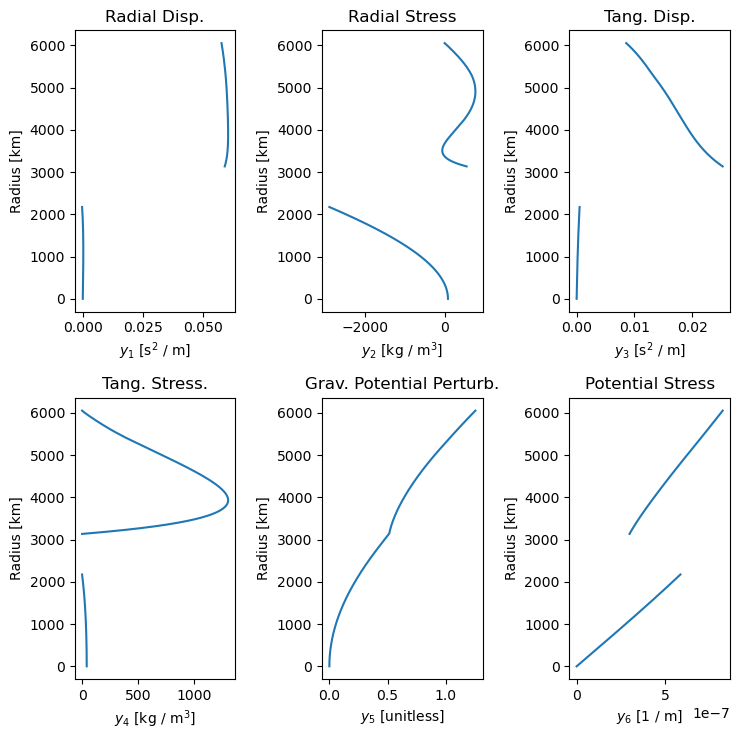

In [4]:
tidal_y = radial_solver(*function_inputs, **function_kwargs)

_ = yplot(tidal_y, radius_array)

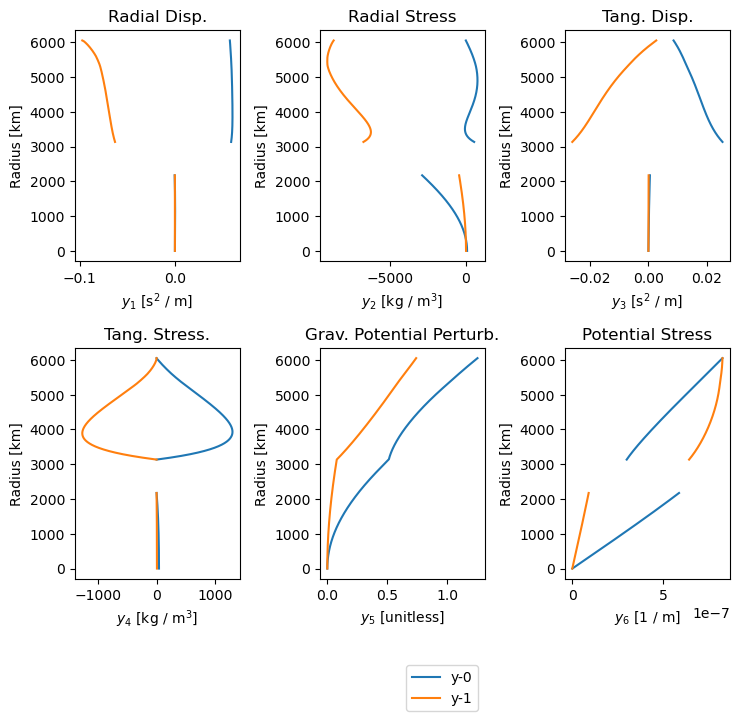

In [5]:
tidal_y, load_y = radial_solver(*function_inputs, **function_kwargs_load)

_ = yplot([tidal_y, load_y], [radius_array, radius_array])

## Baseline

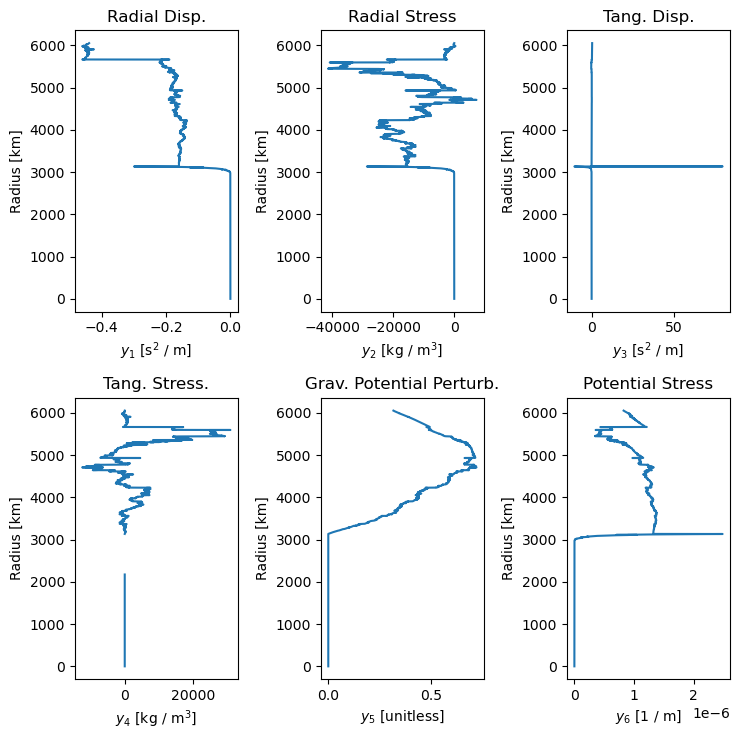

12.5 s ± 88.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# Scipy
# scipy RK45 - 95.6ms
# 107ms

tidal_y = radial_solver(*function_inputs, **function_kwargs)

_ = yplot(tidal_y, radius_array)

%timeit radial_solver(*function_inputs, **function_kwargs)

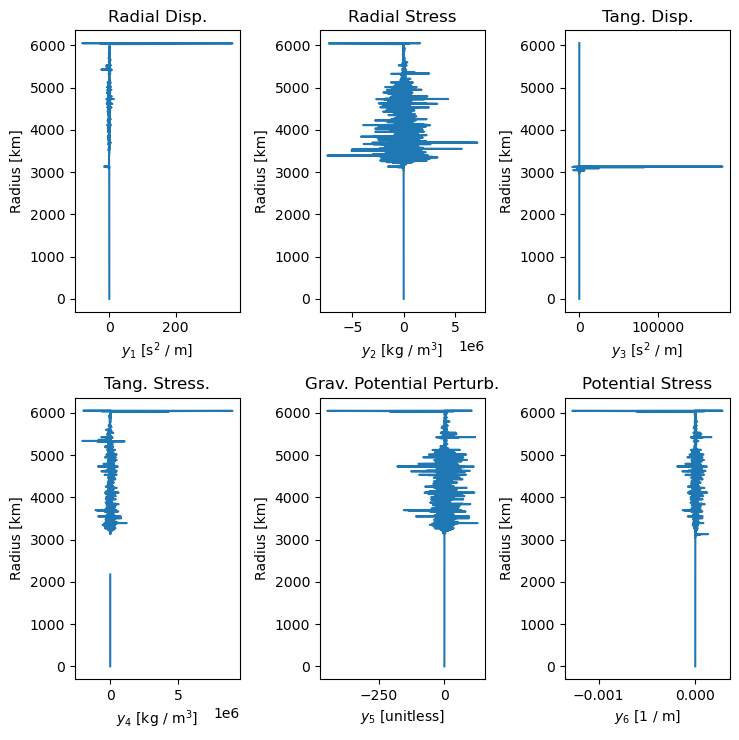

721 ms ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
# CyRK - Numba
# 10.2 ms
# 8.4 ms

tidal_y = radial_solver(*function_inputs, **function_kwargs_nb)

_ = yplot(tidal_y, radius_array)

%timeit radial_solver(*function_inputs, **function_kwargs_nb)

In [8]:
%load_ext line_profiler

In [9]:
%lprun -f radial_solver radial_solver(*function_inputs, **function_kwargs_nb)

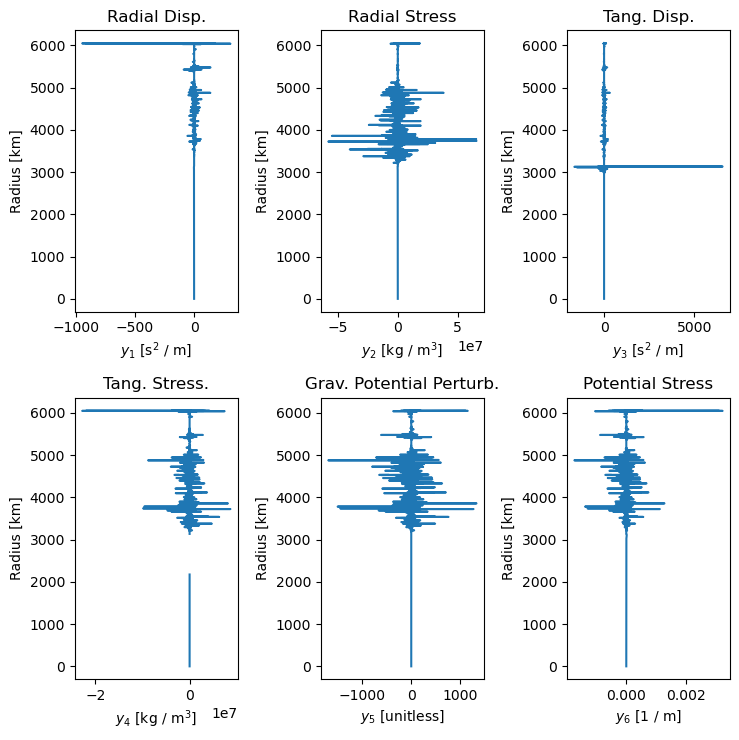

4.05 s ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
# TidalPy Pure Numba
# 7.94 ms
# 7 ms

tidal_y = tidal_y_solver_numba(*function_inputs, **function_kwargs_pure_nb)

_ = yplot(tidal_y, radius_array)

%timeit tidal_y_solver_numba(*function_inputs, **function_kwargs_pure_nb)

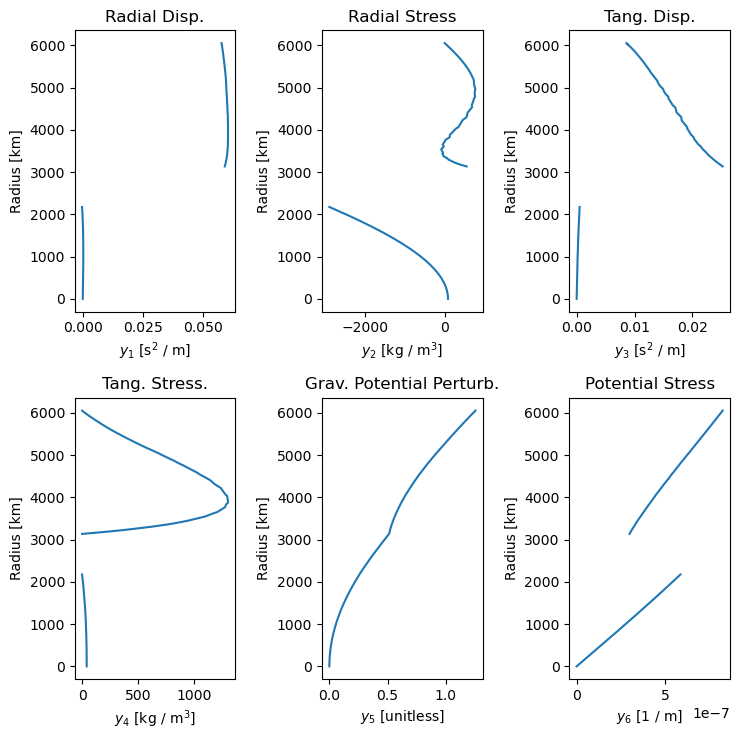

81.8 ms ± 5.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
# CyRK - Cython
# RK45 = 81.8 ms
# DOP853 = 118ms
# RK23 = 

tidal_y = radial_solver(*function_inputs, **function_kwargs_cy)

_ = yplot(tidal_y, radius_array)

%timeit radial_solver(*function_inputs, **function_kwargs_cy)

In [12]:
# Julia
# RK45 = 897 ms
# Tsit5 = 171ms

tidal_y = radial_solver(*function_inputs, **function_kwargs_jl)

_ = yplot(tidal_y, radius_array)

%timeit radial_solver(*function_inputs, **function_kwargs_jl)

ImportError: Julia package not found. Can not load ODE solver.